# Acquire and Summarize

1. Acquire data from the cloud database.

    - You will want to end with a single dataframe. Include the logerror field and all other fields related to the properties that are available. You will end up using all the tables in the database.
    - Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid. - Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction. (Hint: read the docs for the .duplicated method) - Only include properties that have a latitude and longitude value.

2. Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

3.Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

In [1]:
#tabular data imports :
import pandas as pd
import numpy as np
import env
from env import user, password, host
from pydataset import data

# visualization imports:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# success metrics from earlier in the week: mean squared error and r^2 explained variance
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

#stats
from scipy.stats import pearsonr, spearmanr
from scipy.stats import shapiro

import warnings
warnings.filterwarnings("ignore")
import wrangle as w
import os
directory = os.getcwd()
pd.set_option('display.max_columns', None)

In [2]:
df = w.acquire_zillow()
df.head(3)

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,airconditioningdesc,logerror,transactiondate,propertylandusedesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc
0,1,10759547,NaN,NaN,NaN,0.0,0.0,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34140430.0,-118625364.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,261.0,LCA11*,6.037800e+07,37688.0,3101.0,NaN,96337.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,None,NaN,NaN,None,0.055619,2017-01-01,Single Family Residential,None,None,None,Single Family Residential,None
1,15,11193347,NaN,NaN,NaN,0.0,0.0,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34585014.0,-118162010.0,11975.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PDA1*,6.037910e+07,40227.0,3101.0,NaN,97329.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,2016.0,10.0,NaN,None,NaN,NaN,None,0.008669,2017-01-02,Single Family Residential,None,None,None,Single Family Residential,None
2,16,11215747,NaN,NaN,NaN,0.0,0.0,None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34563376.0,-118019104.0,9403.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,PDA21*,6.037911e+07,40227.0,3101.0,NaN,97330.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,2016.0,10.0,NaN,None,NaN,NaN,None,-0.021896,2017-01-02,Single Family Residential,None,None,None,Single Family Residential,None


In [3]:
w.summarize(df)

--------------------------------
--------------------------------
Information on DataFrame: 
Shape of Dataframe: (56079, 68)
--------------------------------
Basic DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56079 entries, 0 to 56078
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            56079 non-null  int64  
 1   parcelid                      56079 non-null  int64  
 2   airconditioningtypeid         13650 non-null  float64
 3   architecturalstyletypeid      61 non-null     float64
 4   basementsqft                  43 non-null     float64
 5   bathroomcnt                   56079 non-null  float64
 6   bedroomcnt                    56079 non-null  float64
 7   buildingclasstypeid           0 non-null      object 
 8   buildingqualitytypeid         36990 non-null  float64
 9   calculatedbathnbr             55693 non-null  float64
 10

## There are many columns that have more than 70% of their cells empty. For the majority of those features, i will be dropping the entire column, for some i will replace the nan's with "0" as in the case of garage and/or pool, i will assume that they dont have any if they are empty.  

#Prepare

1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer.

2. Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

- The input:
    - A dataframe
    - A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).
    - A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing).
- The output:
    - The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.
    - hint:
    - Look up the dropna documentation.
    - You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.
Encapsulate your work inside of functions in a wrangle_zillow.py module.

### Many columns were dropped based on 60% or more of their data was missing.  Also, in some cases, like poolcnt i kept the column and imputed '0' for NaN as i assume the only cells that include data HAVE a pool.  other columns also include: 'garagecarcnt','decktypeid','fireplacecnt','hashottuborspa'.

In [4]:
df = w.prep_zillow(w.get_zillow_data())

In [5]:
df.head(3)

,parcelid,bathrooms,bedrooms,deck_type,sqft,county,fireplacecnt,garage_cnt,hot_tub_spa,latitude,longitude,lot_sqft,poolcnt,county_code,propertylandusetypeid,city_id,zipcode,yearbuilt,numberofstories,tax_structure,tax_value,tax_land,taxamount,log_error,tran_date,propertylandusedesc.1
id,,,,,,,,,,,,,,,,,,,,,,,,,,
20,11324547,2.0,4,0,3633,LA,0.0,0.0,0.0,34560018.0,-118169806.0,9826.0,0,0100,261.0,40227,97329.0,2005,1.0,222321.0,296425,74104.0,6941.39,0.042463,2017-01-02,Single Family Residential
33,11585547,2.0,3,0,2077,LA,0.0,0.0,0.0,34012977.0,-118479243.0,6490.0,0,0100,261.0,26964,96152.0,1926,1.0,210192.0,646760,436568.0,7924.68,-0.040807,2017-01-02,Single Family Residential
62,11954547,0.0,0,0,1200,LA,0.0,0.0,0.0,34097714.0,-118248712.0,4054.0,0,0109,261.0,12447,96020.0,1972,1.0,595.0,5328,4733.0,91.60,0.069858,2017-01-02,Single Family Residential


In [6]:
w.summarize(df)

--------------------------------
--------------------------------
Information on DataFrame: 
Shape of Dataframe: (54503, 26)
--------------------------------
Basic DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 54503 entries, 20 to 77611
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   parcelid               54503 non-null  int64  
 1   bathrooms              54503 non-null  float64
 2   bedrooms               54503 non-null  int64  
 3   deck_type              54503 non-null  int64  
 4   sqft                   54503 non-null  int64  
 5   county                 54503 non-null  object 
 6   fireplacecnt           54503 non-null  float64
 7   garage_cnt             54503 non-null  float64
 8   hot_tub_spa            54503 non-null  float64
 9   latitude               54503 non-null  float64
 10  longitude              54503 non-null  float64
 11  lot_sqft               54503 

In [7]:
df = df.drop(columns = 'propertylandusedesc.1')

## Mall Customers

In [8]:
sql = 'select * from customers'

In [9]:
# acquire mall customers data using the query:

def get_mall_customers(sql):
    url = w.get_db_url('mall_customers')
    mall_df = pd.read_sql(sql, url, index_col='customer_id')
    return mall_df

In [10]:
# acquire data

mall_df = get_mall_customers(sql)

In [11]:
mall_df.head(3)

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6


In [12]:
mall_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [13]:
mall_df.shape

(200, 4)

In [14]:
mall_df.describe()

,age,annual_income,spending_score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [15]:
mall_df.isnull().sum()

gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

In [16]:
mall_df.gender.value_counts()

Female    112
Male       88
Name: gender, dtype: int64

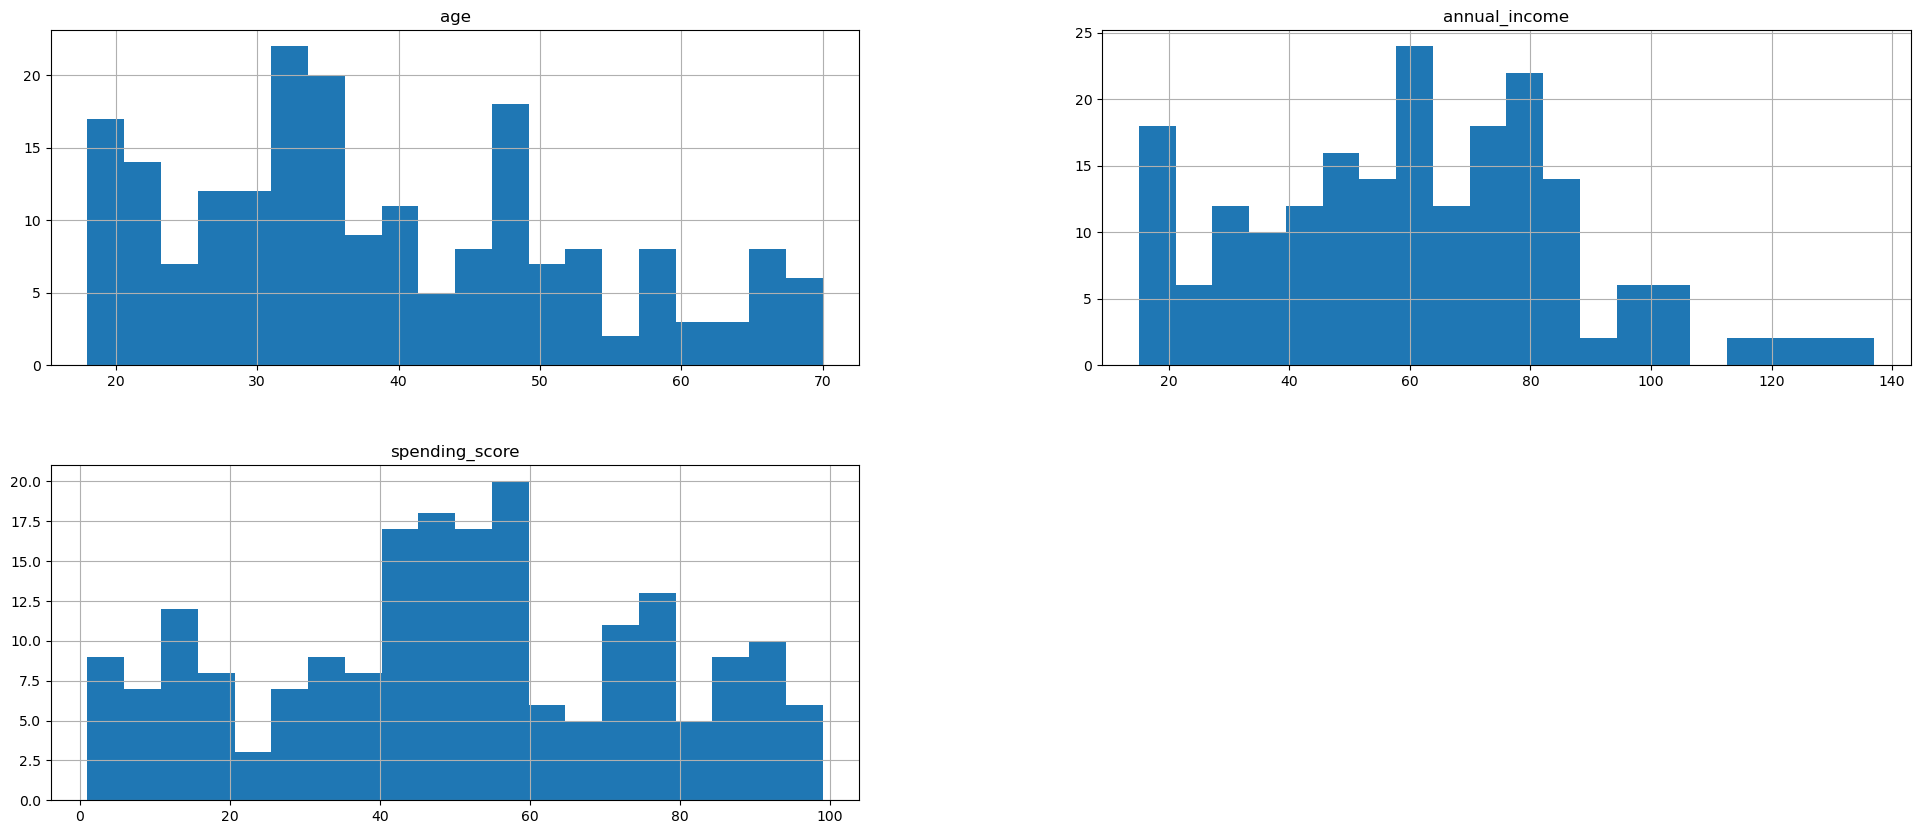

In [17]:
mall_df.hist(figsize=(24, 10), bins=20);

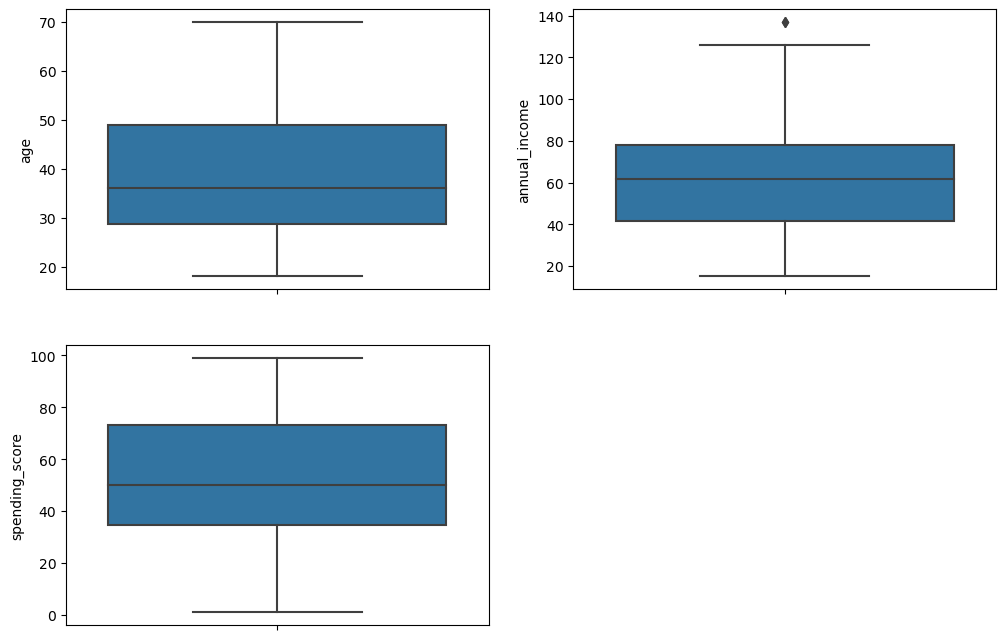

In [18]:
# visualize outliers using boxplots:

plt.figure(figsize = (12,8))
plt.subplot(221)
sns.boxplot(y = mall_df.age)

plt.subplot(222)
sns.boxplot(y = mall_df.annual_income)

plt.subplot(223)
sns.boxplot(y = mall_df.spending_score)
plt.show()

In [19]:
# Calculate q1, q3 and iqr for income

q1 = mall_df.annual_income.quantile(0.25)
q3 = mall_df.annual_income.quantile(0.75)
iqr = q3 - q1
k = 1.5

# calculate upper and lower ranges
upper_bound_income =  q3 + k * iqr
lower_bound_income =  q1 - k * iqr

lower_bound_income, upper_bound_income

(-13.25, 132.75)

In [20]:
mall_df[mall_df.annual_income > upper_bound_income]

,gender,age,annual_income,spending_score
customer_id,,,,
199,Male,32,137,18
200,Male,30,137,83


In [21]:
# function to detect and eliminate outliers using IQR rule

def outlier_function(df, cols, k):
    for col in df[cols]:
        q1 = mall_df.annual_income.quantile(0.25)
        q3 = mall_df.annual_income.quantile(0.75)
        iqr = q3 - q1
        upper_bound =  q3 + k * iqr
        lower_bound =  q1 - k * iqr     
        df = df[(df[col] < upper_bound) & (df[col] > lower_bound)]
    return df

In [22]:
# use the outlier function defined above to handle outliers in numeric columns. k = 1.5

mall_df = outlier_function(mall_df, ['age', 'spending_score', 'annual_income'], 1.5)
mall_df.shape

(198, 4)

In [23]:
mall_df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [24]:
# encode the gender column

dummy_df = pd.get_dummies(mall_df.gender, drop_first=True)
dummy_df.head()

,Male
customer_id,
1,1
2,1
3,0
4,0
5,0


In [25]:
# concat the dummies df with original df. Drop the 'gender' column

mall_df = pd.concat([mall_df, dummy_df], axis=1).drop(columns = ['gender'])
mall_df.head()

,age,annual_income,spending_score,Male
customer_id,,,,
1,19,15,39,1
2,21,15,81,1
3,20,16,6,0
4,23,16,77,0
5,31,17,40,0


In [26]:
train, validate, test = w.split_data(mall_df)


    train -> (118, 4)
    validate -> (40, 4)
    test -> (40, 4)


In [27]:
train.head()

,age,annual_income,spending_score,Male
customer_id,,,,
131,47,71,9,1
30,23,29,87,0
36,21,33,81,0
1,19,15,39,1
191,34,103,23,0


In [28]:
def min_max_scaler(train, valid, test):
    '''
    Uses the train & test datasets created by the split_my_data function
    Returns 3 items: mm_scaler, train_scaled_mm, test_scaled_mm
    This is a linear transformation. Values will lie between 0 and 1
    '''
    num_vars = list(train.select_dtypes('number').columns)
    scaler = MinMaxScaler(copy=True, feature_range=(0,1))
    train[num_vars] = scaler.fit_transform(train[num_vars])
    valid[num_vars] = scaler.transform(valid[num_vars])
    test[num_vars] = scaler.transform(test[num_vars])
    return scaler, train, valid, test

In [29]:
train.select_dtypes('number').columns

Index(['age', 'annual_income', 'spending_score', 'Male'], dtype='object')

In [30]:
scaler, train_scaled, validate_scaled, test_scaled = min_max_scaler(train, validate, test)

In [31]:
train_scaled.head()

,age,annual_income,spending_score,Male
customer_id,,,,
131,0.557692,0.504505,0.081633,1.0
30,0.096154,0.126126,0.877551,0.0
36,0.057692,0.162162,0.816327,0.0
1,0.019231,0.000000,0.387755,1.0
191,0.307692,0.792793,0.224490,0.0


In [32]:
# Write a master wrangle fuction which acquires and prepares the data

def wrangle_mall_df():
    
    # acquire data
    sql = 'select * from customers'
    mall_df = get_mall_customers(sql)
    
    # handle outliers
    mall_df = outlier_function(mall_df, ['age', 'spending_score', 'annual_income'], 1.5)
    
    # get dummy for gender column
    dummy_df = pd.get_dummies(mall_df.gender, drop_first=True)
    mall_df = pd.concat([mall_df, dummy_df], axis=1).drop(columns = ['gender'])
    mall_df.rename(columns= {'Male': 'is_male'}, inplace = True)

    # split the data in train, validate and test
    train, test = train_test_split(mall_df, train_size = 0.8, random_state = 123)
    train, validate = train_test_split(train, train_size = 0.75, random_state = 123)
    
    return min_max_scaler, train, validate, test

In [33]:
# use the wrangle function:

scaler, train, validate, test = wrangle_mall_df()

In [34]:
#scaled the values
scaler, train_scaled, validate_scaled, test_scaled = min_max_scaler(train, validate, test)

In [35]:
train_scaled.head(3)

,age,annual_income,spending_score,is_male
customer_id,,,,
182,0.269231,0.738739,0.867347,0.0
49,0.211538,0.225225,0.418367,0.0
35,0.596154,0.162162,0.132653,0.0


In [36]:
train.head()

,age,annual_income,spending_score,is_male
customer_id,,,,
182,0.269231,0.738739,0.867347,0.0
49,0.211538,0.225225,0.418367,0.0
35,0.596154,0.162162,0.132653,0.0
186,0.230769,0.756757,0.979592,1.0
114,0.019231,0.441441,0.459184,1.0
